# NATURAL LANGUAGE PROCESSING WITH TRANSFORMERS
# Α Pos Tagger trained on UD treebank with fine-tuning a BERT model

# Native BERT implementation

In [1]:
# First install some extra packages
# ! pip install pyconll # for UD treebank reading
# ! pip install bert-tensorflow # for using bert model

In [2]:
import pyconll, pickle, os, random, datetime, warnings, gc, urllib.request, zipfile, collections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, learning_curve, cross_val_score
from sklearn import preprocessing
from sklearn.metrics.classification import UndefinedMetricWarning

from IPython.display import Image 
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [3]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

In [4]:
UD_ENGLISH_TRAIN = 'en_partut-ud-train.conllu'
UD_ENGLISH_DEV = 'en_partut-ud-dev.conllu'
UD_ENGLISH_TEST = 'en_partut-ud-test.conllu'

In [13]:
def download_files():
    print('Downloading English treebank...')
    #urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-dev.conllu', UD_ENGLISH_DEV)
    #urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-test.conllu', UD_ENGLISH_TEST)
    #urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-train.conllu', UD_ENGLISH_TRAIN)
    print('Treebank downloaded.')
    print('Downloading pre-trained BERT model...')
    urllib.request.urlretrieve('https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip', 'uncased_L-12_H-768_A-12.zip')
    print('Pre-trained BERT model downloaded.')
    print('Extracting zip file...')
    zip_ref = zipfile.ZipFile('uncased_L-12_H-768_A-12.zip', 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    print('Zip file extracted.')

First we download English treebank and pre-trained BERT model:

In [10]:
download_files()

Treebank downloaded.
Pre-trained BERT model downloaded.
Extracting zip file...
Zip file extracted.


# Preprocessing

In [14]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos and token.form:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [15]:
train_sentences = read_conllu(UD_ENGLISH_TRAIN)
val_sentences = read_conllu(UD_ENGLISH_DEV)
test_sentences = read_conllu(UD_ENGLISH_TEST)

Print some statistics

In [16]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))
print(40*'*')
print("Total sentences in dataset:", len(train_sentences)+len(val_sentences)+len(test_sentences))

Tagged sentences in train set:  1781
Tagged words in train set: 43504
Tagged sentences in dev set:  156
Tagged words in dev set: 2722
Tagged sentences in test set:  153
Tagged words in test set: 3408
****************************************
Total sentences in dataset: 2090


In [17]:
print(train_sentences[0])

[('distribution', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('license', 'NOUN'), ('does', 'AUX'), ('not', 'PART'), ('create', 'VERB'), ('an', 'DET'), ('attorney', 'NOUN'), ('-', 'PUNCT'), ('client', 'NOUN'), ('relationship', 'NOUN'), ('.', 'PUNCT')]


In [18]:
# Some usefull functions
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

In [19]:
train_text = text_sequence(train_sentences)
test_text = text_sequence(test_sentences)
val_text = text_sequence(val_sentences)

train_label = tag_sequence(train_sentences)
test_label= tag_sequence(test_sentences)
val_label= tag_sequence(val_sentences)

In [20]:
MAX_SEQUENCE_LENGTH=len(max(train_sentences+val_sentences+test_sentences, key=len))
print('Max sentence length:',MAX_SEQUENCE_LENGTH)

Max sentence length: 209


In [21]:
train_text[0:1], train_label[0:1]

([['distribution',
   'of',
   'this',
   'license',
   'does',
   'not',
   'create',
   'an',
   'attorney',
   '-',
   'client',
   'relationship',
   '.']],
 [['NOUN',
   'ADP',
   'DET',
   'NOUN',
   'AUX',
   'PART',
   'VERB',
   'DET',
   'NOUN',
   'PUNCT',
   'NOUN',
   'NOUN',
   'PUNCT']])

Convert our UD dataset to NER conllu format and save in 'data' directory:

In [22]:
def convert_ner_format(text, label, file):
    with open(file, 'w') as f:
        words=0
        i=0
        for zip_i in zip(text, label):
            a, b = tuple(zip_i)
            for r in range(len(a)):
                item = a[r]+' '+b[r]
                f.write("%s\n" % item)
                words+=1
            f.write("\n")
            i+=1
            #if i==3: break
    print('Sentences:',i,'Words:',words)

In [23]:
convert_ner_format(train_text, train_label, 'data/train.txt')
convert_ner_format(test_text, test_label, 'data/test.txt')
convert_ner_format(val_text, val_label, 'data/dev.txt')

Sentences: 1781 Words: 43504
Sentences: 153 Words: 3408
Sentences: 156 Words: 2722


# Run BERT fine-tuning

In [24]:
MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH+2 # +2 for [CLS], [SEP] tokens

In [25]:
! rm -rf ./output/result_dir/*

In [29]:
%run bert_pos.py   \
    --task_name="POS"  \
    --do_lower_case=False \ 
    --crf=False \
    --do_train=True   \
    --do_eval=True   \
    --do_predict=True \
    --data_dir=data   \
    --vocab_file=uncased_L-12_H-768_A-12/vocab.txt  \
    --bert_config_file=uncased_L-12_H-768_A-12/bert_config.json \
    --init_checkpoint=uncased_L-12_H-768_A-12/bert_model.ckpt   \
    --max_seq_length=$MAX_SEQUENCE_LENGTH  \
    --train_batch_size=16   \
    --learning_rate=2e-5   \
    --num_train_epochs=4.0   \
    --output_dir=./output/result_dir

W0305 10:37:09.425441 140735595373440 estimator.py:1924] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x12bce56a8>) includes params argument, but params are not passed to Estimator.
I0305 10:37:09.426982 140735595373440 estimator.py:201] Using config: {'_model_dir': './output/result_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12a083c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '',


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I0305 10:37:11.106344 140735595373440 bert_pos.py:623] ***** Running training *****
I0305 10:37:11.107048 140735595373440 bert_pos.py:624]   Num examples = 1614
I0305 10:37:11.107576 140735595373440 bert_pos.py:625]   Batch size = 16
I0305 10:37:11.108204 140735595373440 bert_pos.py:626]   Num steps = 403
W0305 10:37:11.121157 140735595373440 deprecation.py:323] From /Users/jangela/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
W0305 10:37:11.155674 140735595373440 deprecation.py:323] From /Users/jangela/Desktop/pos-tagger-bert-tensorflow-master/bert_pos.py:363: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
I0305 10:37:11.177505 140735595373440 estimator.py:1111] 

I0305 10:37:15.203546 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0305 10:37:15.204214 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0305 10:37:15.205974 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0305 10:37:15.208602 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0305 10:37:15.209245 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0305 10:37:15.211609 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0305 10:37:15.212315 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_2/attention/output/

I0305 10:37:15.263952 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
I0305 10:37:15.265046 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*
I0305 10:37:15.265584 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*
I0305 10:37:15.266362 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*
I0305 10:37:15.267099 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0305 10:37:15.268321 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
I0305 10:37:15.269755 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (

I0305 10:37:15.325383 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0305 10:37:15.326626 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0305 10:37:15.327764 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0305 10:37:15.328783 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0305 10:37:15.330487 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0305 10:37:15.331287 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0305 10:37:15.332108 140735595373440 bert_pos.py:495]   name = bert/encoder/layer_9/attention/output/

I0305 10:37:29.891123 140735595373440 session_manager.py:493] Done running local_init_op.
I0305 10:37:36.363247 140735595373440 basic_session_run_hooks.py:594] Saving checkpoints for 0 into ./output/result_dir/model.ckpt.
I0305 12:41:29.805646 140735595373440 tpu_estimator.py:1858] global_step/sec: 0.0135294
I0305 12:41:30.000367 140735595373440 tpu_estimator.py:1859] examples/sec: 0.21647
I0305 13:09:10.691898 140735595373440 error_handling.py:93] training_loop marked as finished


KeyboardInterrupt: 

# Evaluation

## Classification report

Results are stored in *'./output/result_dir/'*. Lets see the classification report:

In [19]:
predictions ='./output/result_dir/label_test.txt'

In [20]:
y_true = []
y_pred = []
with open(predictions) as fp:
    for line in fp:
        line = line.split()
        if not line[0].startswith('##') and not line[1].startswith('##') :#and not line[2].startswith('##'):
            y_true.append(line[1])
            y_pred.append(line[2])

In [21]:
len(y_true), len(y_pred)

(3408, 3408)

In [22]:
name='Bert fine-tuned model'
print('\n------------ Result of {} ----------\n'.format(name))
print(classification_report(y_true, y_pred, digits=4))


------------ Result of Bert fine-tuned model ----------

              precision    recall  f1-score   support

          ##     0.0000    0.0000    0.0000         0
         ADJ     0.9217    0.8929    0.9070       224
         ADP     0.9817    0.9877    0.9847       488
         ADV     0.9302    0.9160    0.9231       131
         AUX     0.9957    1.0000    0.9979       234
       CCONJ     0.9896    0.9896    0.9896        96
         DET     0.9955    1.0000    0.9977       439
        INTJ     1.0000    1.0000    1.0000         2
        NOUN     0.9736    0.9788    0.9762       753
         NUM     0.9385    1.0000    0.9683        61
        PART     0.9565    1.0000    0.9778        66
        PRON     1.0000    0.9340    0.9659       106
       PROPN     0.9405    0.8778    0.9080        90
       PUNCT     1.0000    0.9971    0.9985       339
       SCONJ     0.9565    0.8627    0.9072        51
        VERB     0.9580    0.9785    0.9681       326
           X     1.0000

In [23]:
print("Accuracy: {0:.4f}".format(accuracy_score(y_true, y_pred)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_true, y_pred, average='macro')))

Accuracy: 0.9733
f1-macro score: 0.9100


## Confusion matrix

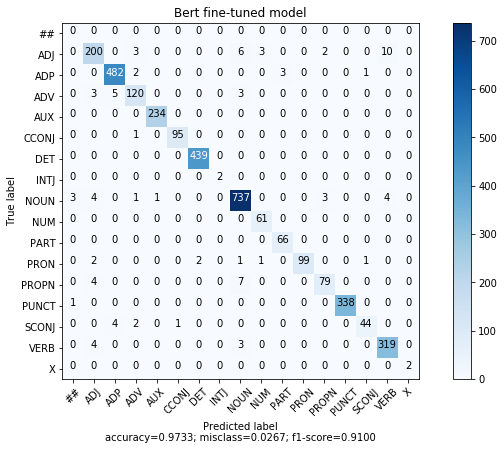

In [26]:
tags = sorted(set(y_true+y_pred))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(f1_score(y_true, y_pred, average='macro'), cnf_matrix, target_names=tags, title=name, normalize=False)

## Note

**##** label is comming from original-to-tokenized alignment code in function <font color=blue>convert_single_example(ex_index, example, label_list, max_seq_length, tokenizer, mode)</font>  in *bert_pos.py*. Following suggestions from [WordPiece tokenization](https://github.com/google-research/bert) part, for pos tagging task input sentences are converted to the following format:

In [1]:
# orig_tokens = ["John", "Johanson", "'s",  "house"]
# labels      = ["NNP",  "NNP",      "POS", "NN"]

# bert_tokens = ['[CLS]", "john", "johan", "##son", "'",   "s",  "house", "[SEP]"]
# bert_labels = ['[CLS]", "NNP",  "NNP",   "##",    "POS", "##", "NN",    "[SEP]"]